Install Libraries

In [1]:
!pip install --upgrade speechbrain
!pip install mir_eval
!pip install -U asteroid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Generate data set

In [2]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Project/dataset_2500.zip'
with zipfile.ZipFile(zip_path, "r") as zip_ref:
  zip_ref.extractall('./dataset')
results_path = '/content/drive/MyDrive/Results.zip'
with zipfile.ZipFile(results_path, "r") as zip_ref:
  zip_ref.extractall('./convTasNet')

Mounted at /content/drive


Hparams yaml File


In [4]:

!mkdir /content/dataset/metadata
!mkdir /content/dataset/metadata/test
!mkdir /content/dataset/metadata/train
!mkdir /content/dataset/metadata/validate
!mv /content/dataset/test/metadata.csv /content/dataset/metadata/test/
!mv /content/dataset/train/metadata.csv /content/dataset/metadata/train/
!mv /content/dataset/validate/metadata.csv /content/dataset/metadata/validate/
# !rm -rf './hparams'
!mkdir './hparams'
!cp '/content/drive/MyDrive/Project/sepformer.yml' './hparams/'
!cp -r '/content/drive/MyDrive/Project/pretrained_convtasnet' './'
!cp -r '/content/drive/MyDrive/Project/VoxLingua' './'
# !cp '/content/drive/MyDrive/Project/conVasNet.yml' './hparams/'
!cp '/content/drive/MyDrive/Project/conVasNet_p.yml' './hparams/'
!cp '/content/drive/MyDrive/Project/preprocess_dynamic_mixing.py' './'
!cp '/content/drive/MyDrive/Project/dynamic_mixing.py' './'
!cp '/content/drive/MyDrive/Project/prepare_data.py' './'
!cp -r '/content/drive/MyDrive/Project/results_80' './'
# !cp -r '/content/drive/MyDrive/Project/results' './'
!cp -r '/content/drive/MyDrive/Project/results_200' './'
!cp '/content/drive/MyDrive/Project/conVasNet_asteroid.yml' './hparams'
!cp '/content/drive/MyDrive/Project/label_encoder.txt' './'

mkdir: cannot create directory ‘/content/dataset/metadata’: File exists
mkdir: cannot create directory ‘/content/dataset/metadata/test’: File exists
mkdir: cannot create directory ‘/content/dataset/metadata/train’: File exists
mkdir: cannot create directory ‘/content/dataset/metadata/validate’: File exists
mv: cannot stat '/content/dataset/test/metadata.csv': No such file or directory
mv: cannot stat '/content/dataset/train/metadata.csv': No such file or directory
mv: cannot stat '/content/dataset/validate/metadata.csv': No such file or directory
mkdir: cannot create directory ‘./hparams’: File exists
cp: cannot stat '/content/drive/MyDrive/Project/results_80': No such file or directory


Prepare dataset

In [ ]:
def assign_lang_label(language):
  if language =='as':
    return 'as: Assamese'

  elif language == 'bn':
    return 'bn: Bengali'

  elif language == 'en' or language == 'Indian_eng':
    return 'en: English'

  elif language == 'gu':
    return 'gu: Gujarati'

  elif language == 'hi':
    return 'hi: Hindi'

  elif language == 'kn':
    return 'kn: Kannada'

  elif language == 'ml':
    return 'ml: Malayalam'

  elif language == 'mr':
    return 'mr: Marathi'

  elif language == 'ne':
    return 'ne: Nepali'

  elif language == 'pa':
    return 'pa: Panjabi'

  elif language == 'sa':
    return 'sa: Sanskrit'

  elif language == 'sd':
    return 'sd: Sindhi'

  elif language == 'ta':
    return 'ta: Tamil'

  elif language == 'te':
    return 'te: Telugu'

  elif language == 'ur':
    return 'ur: Urdu'



def dataio_prep(hparams):
    """Creates data processing pipeline"""

    # 1. Define datasets
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_data"],
        replacements={"data_root": hparams["data_folder"]},
    )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_data"],
        replacements={"data_root": hparams["data_folder"]},
    )

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_data"],
        replacements={"data_root": hparams["data_folder"]},
    )

    datasets = [train_data, valid_data, test_data]

    # 2. Provide audio pipelines

    @sb.utils.data_pipeline.takes("mix_wav")
    @sb.utils.data_pipeline.provides("mix_sig")
    def audio_pipeline_mix(mix_wav):
        mix_sig = sb.dataio.dataio.read_audio(mix_wav)
        return mix_sig

    @sb.utils.data_pipeline.takes("s1_wav")
    @sb.utils.data_pipeline.provides("s1_sig")
    def audio_pipeline_s1(s1_wav):
        s1_sig = sb.dataio.dataio.read_audio(s1_wav)
        return s1_sig

    @sb.utils.data_pipeline.takes("s2_wav")
    @sb.utils.data_pipeline.provides("s2_sig")
    def audio_pipeline_s2(s2_wav):
        s2_sig = sb.dataio.dataio.read_audio(s2_wav)
        return s2_sig

    @sb.utils.data_pipeline.takes("languages")
    @sb.utils.data_pipeline.provides("lang_id")
    def lang_id_pipeline(lang_str):
      lang_id = lang_str.split(',')
      # print(f"language String = {lang_str}, lang_id = {lang_id}")
      lang_id = [assign_lang_label(lang) for lang in lang_id]
      yield encode_languages(lang_id)

    @sb.utils.data_pipeline.takes("length")
    @sb.utils.data_pipeline.provides("lens")
    def length_pipeline(length):
      return length

    if hparams["num_spks"] == 3:

        @sb.utils.data_pipeline.takes("s3_wav")
        @sb.utils.data_pipeline.provides("s3_sig")
        def audio_pipeline_s3(s3_wav):
            s3_sig = sb.dataio.dataio.read_audio(s3_wav)
            return s3_sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_mix)
    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_s1)
    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_s2)
    sb.dataio.dataset.add_dynamic_item(datasets, lang_id_pipeline)
    sb.dataio.dataset.add_dynamic_item(datasets, length_pipeline)
    if hparams["num_spks"] == 3:
      sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_s3)
      sb.dataio.dataset.set_output_keys(datasets, ["id", "mix_sig", "s1_sig", "s2_sig", "s3_sig", "lang_id", "lens"])
    else:
      sb.dataio.dataset.set_output_keys(datasets, ["id", "mix_sig", "s1_sig", "s2_sig", "lang_id", "lens"])

    return train_data, valid_data, test_data

def encode_languages(language_list):
  label = []

  for lang in language_list:
    idx = label_encoder.encode_label(lang)
    label.append(idx)
  label = torch.tensor(label)
  # print(f"Label = {label}")
  return label

Model

In [ ]:
import csv
import os
import sys
import io

import numpy as np
import math
import torch
from  speechbrain.nnet.losses import PitWrapper
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import matplotlib.pyplot as plt
from hyperpyyaml import load_hyperpyyaml
from tqdm import tqdm

import speechbrain as sb
import speechbrain.nnet.schedulers as schedulers
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.logger import get_logger
from speechbrain.utils.train_logger import FileTrainLogger
from speechbrain.nnet.losses import bce_loss, PitWrapper
from speechbrain.utils.metric_stats import ClassificationStats
from speechbrain.utils.Accuracy import AccuracyStats

class MultiTask(sb.Brain):
  def on_stage_start(self, stage, epoch):
    # if stage != sb.Stage.TRAIN:
      # self.error_metrics = self.hparams.error_stats()
    self.epoch_acc_p = []
    self.epoch_acc = []
    self.print_num =0;
    if stage == sb.Stage.TRAIN and epoch<21:
      self.hparams.delta_separate_loss = 1.0
      self.hparams.delta_lang_loss = 0.0
      for name in ['compute_features', 'embedding_model', 'classifier', 'mean_var_norm']:
        for param in getattr(self.modules, name).parameters():
            param.requires_grad = False
    elif stage == sb.Stage.TRAIN and epoch == 80:
      self.hparams.delta_separate_loss =0.8
      self.hparams.delta_lang_loss = 0.2
      logger.info("Unfreezing ECAPA")
      for name in ['compute_features', 'embedding_model', 'classifier', 'mean_var_norm' ]:
          for param in getattr(self.modules, name).parameters():
              param.requires_grad = True
      unfrozen_params = filter(lambda p: p.requires_grad, self.modules.parameters())
      self.optimizer = torch.optim.Adam(unfrozen_params, lr=0.00001, weight_decay=0)
    print(f"Delta lang loss = {self.hparams.delta_lang_loss}, Delta separate loss = {self.hparams.delta_separate_loss}")
    self.uttid = [0]
    if stage in [sb.Stage.VALID, sb.Stage.TEST]:
      self.valid_acc = AccuracyStats()
      self.error_metrics = self.hparams.error_stats
    self.file_logger = FileTrainLogger("/content/results/print_statements")

  def dump_waveform(self, waveform, name,  sample_rate=16000, out_dir="debug_audio"):
    os.makedirs(out_dir, exist_ok=True)

    # Save waveform
    path = os.path.join(out_dir, f"{name}.wav")
    torchaudio.save(path, waveform.unsqueeze(0).cpu(), sample_rate)
    wav = waveform
    wav = wav.detach().cpu().numpy()
    # Plot
    plt.figure(figsize=(10, 3))
    plt.plot(wav)
    plt.title(name)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{name}_{self.uttid[0]}.png"))
    plt.close()


  def compute_forward(self, mix, targets, lang_id,  stage):
    mix, mix_lens = mix
    mix, mix_lens = mix.to(self.device), mix_lens.to(self.device)
    targets = torch.stack([t.data for t in targets], dim=-1).to(self.device)
    if stage == sb.Stage.TRAIN:
      with torch.no_grad():
        if self.hparams.use_speedperturb:
            mix, targets = self.add_speed_perturb(targets, mix_lens)

            mix = targets.sum(-1)

        if self.hparams.use_wavedrop:
            mix = self.hparams.drop_chunk(mix, mix_lens)
            mix = self.hparams.drop_freq(mix)

        if self.hparams.limit_training_signal_len:
            mix, targets = self.cut_signals(mix, targets)
    #ConvTasNet
    est_source = self.modules.convTasNet(mix)
    #Making two batches
    est_source = est_source.permute(0,2,1)
    batch_size, seq_len, num_spks = est_source.shape
    est_source_permute = est_source.permute(2, 0, 1)  # Now shape is [num_spks, batch, time]
    est_source_combined = est_source_permute.reshape(batch_size * num_spks, seq_len)
    est_source_combined = est_source_combined / (est_source_combined.abs().max(dim=1, keepdim=True)[0] + 1e-8)
    mix_len_combined = mix_lens.repeat(num_spks)
    #ECAPA
    feats = self.modules.compute_features(est_source_combined)
    feats = self.modules.mean_var_norm(feats, mix_len_combined)
    embeddings = self.modules.embedding_model(feats, mix_len_combined)
    outputs = self.modules.classifier(embeddings)
    pred_lang_id = outputs.view(batch_size, num_spks, -1)
    #Check Infinite
    if torch.isnan(embeddings).any() or torch.isnan(outputs).any():
      print("Embeddings min/max:", embeddings.min(), embeddings.max())
      print(f"Embeddings: {embeddings}, Embeddings length: {embeddings.shape}")
      print("Classifier output min/max:", outputs.min(), outputs.max())
      print(f"outputs: {outputs}, outputs length: {outputs.shape}")
      print(f"pred_lang_id: {pred_lang_id}, pred_lang_id length: {pred_lang_id.shape}")
    #Print
    if self.uttid[0] % 1000 == 0:
      probs = torch.sigmoid(pred_lang_id)  # limit how often you dump
      target_lang = lang_id.squeeze(0)
      pred_lang = torch.argmax(probs, dim = -1)
      for spk_idx in range(2):
        # print(f"est_source: {est_source_combined}")
        wav = wav = est_source_combined[spk_idx]
        self.dump_waveform(wav,f"{stage}_{pred_lang[0]}_{target_lang}_12_utt{self.uttid[0]}_spk{spk_idx}")
    return est_source, targets, lang_id, mix_lens, pred_lang_id, embeddings

  def lang_accuracy(self, lang_id, pred_lang_id, log):
    # lang_id_new = lang_id.squeeze(0)
    probs = torch.sigmoid(pred_lang_id)
    targets = lang_id.data.squeeze(0).long()
    # print(f"probs = {probs}, targets = {targets}")
    # print(f"probs = {probs}, pred_lang_id {pred_lang_id}")
    # print(f"lang_id = {lang_id}")
    acc1_s = max((probs[0,targets[0]]+ probs[1,targets[1]]), (probs[0,targets[1]]+ probs[1,targets[0]]))/2
    preds = torch.argmax(pred_lang_id, dim=-1)
    # print(f"preds = {preds}")
    # targets = torch.argmax(lang_id_new, dim=-1)
    if(log):
      self.file_logger.log_stats(
          stats_meta = {
              "stage": "VALID",
              "preds": preds,
              "targets": targets,
              "probs": probs
          },verbose=False

      )
    acc1_p = int(preds[0] == targets[0]) + int(preds[1] == targets[1])
    acc2_p = int(preds[0] == targets[1]) + int(preds[1] == targets[0])
    return acc1_s, max(acc1_p, acc2_p)/2

  def compute_objectives(self, est_source, targets, lang_id, lens, pred_lang_id,stage, uttid):
    lang_id = lang_id.data.float().to(pred_lang_id.device)
    predicted_lang_id = pred_lang_id.squeeze(0)
    target = lang_id.squeeze(0).long()
    # print(f"target = {target}, pred_lang_id = {pred_lang_id}")
    separate_loss = self.hparams.loss(targets, est_source)
    lang_loss = torch.min(torch.stack([self.hparams.lang_loss(predicted_lang_id, target), self.hparams.lang_loss(predicted_lang_id,target.flip(0))]))
    loss = self.hparams.delta_lang_loss*lang_loss + self.hparams.delta_separate_loss*separate_loss
    return loss,lang_loss,separate_loss

  def fit_batch(self,batch):
    mixture = batch.mix_sig
    targets = [batch.s1_sig, batch.s2_sig]
    lang_id = batch.lang_id.data
    self.uttid[0] = self.uttid[0] + 1
    with torch.amp.autocast(device_type='cuda', enabled=False):
      est_source, targets, lang_id, lens, pred_lang_id,embeddings = self.compute_forward(
        mixture, targets, lang_id, sb.Stage.TRAIN
      )
      # print(f"predictions: {pred_lang_id}, targets: {targets}")
      loss,lang_loss,separate_loss = self.compute_objectives(
        est_source, targets, lang_id, lens, pred_lang_id,sb.Stage.TRAIN, self.uttid
      )
      if self.uttid[0]%1000 == 0:
        self.file_logger.log_stats(stats_meta={
            "stage": "Train",
            "Loss":loss,
            "Lang loss":lang_loss,
            "separate loss":separate_loss,
            "Est_source" :est_source,
            "targets": targets,
            "lang_id":lang_id,
            "lens":lens,
            "pred_lang_id":pred_lang_id}, verbose=False)

      # print(f"loss: {loss}")
      if self.hparams.threshold_byloss:
        th = self.hparams.threshold
        loss = loss[loss > th]
        if loss.nelement() > 0:
            loss = loss.mean()
            lang_loss = lang_loss.mean()
            separate_loss = separate_loss.mean()
      else:
        loss = loss.mean()
        lang_loss = lang_loss.mean()
        separate_loss = separate_loss.mean()

    if loss.nelement() > 0 and loss < self.hparams.loss_upper_lim:
      self.scaler.scale(loss).backward()
      if self.hparams.clip_grad_norm >= 0:
        self.scaler.unscale_(self.optimizer)
        torch.nn.utils.clip_grad_norm_(
          self.modules.parameters(),
          self.hparams.clip_grad_norm,
        )
      self.scaler.step(self.optimizer)
      self.scaler.update()
    else:
      self.nonfinite_count += 1
      logger.info(
        "infinite loss or empty loss! it happened {} times so far - skipping this batch".format(
          self.nonfinite_count
        )
      )
      loss.data = torch.tensor(0.0).to(self.device)
      lang_loss.data = torch.tensor(0.0).to(self.device)
      separate_loss.data = torch.tensor(0.0).to(self.device)
    self.optimizer.zero_grad()

    return loss.detach().cpu()


  def evaluate_batch(self, batch, stage):

    """Computations needed for validation/test batches"""
    snt_id = batch.id
    mixture = batch.mix_sig
    targets = [batch.s1_sig, batch.s2_sig]
    lang_id = batch.lang_id.data
    self.uttid[0] = self.uttid[0] + 1
    if self.hparams.num_spks == 3:
      targets.append(batch.s3_sig)

    with torch.no_grad():
      # compute_forward returns multiple values for multi-task
      est_source, targets, lang_id, lens, pred_lang_id, embeddings = self.compute_forward(
        mixture, targets, lang_id,  stage
      )
      # compute_objectives combines both tasks into a single loss
      loss,lang_loss,separate_loss = self.compute_objectives(
        est_source, targets, lang_id, lens, pred_lang_id, stage, self.uttid
      )
      lang_id = lang_id.data.float().to(pred_lang_id.device)
      if(self.uttid[0]%20 ==0):
        log_valid = True
      else:
        log_valid = False
      # self.accuracy.append(pred_lang_id, lang_id.unsqueeze(1), lens)
      for i in range(0,self.hparams.batch_size):
        lang_acc_s,lang_acc_p = self.lang_accuracy(lang_id[i],pred_lang_id[i].squeeze(0),log_valid)
        self.epoch_acc.append(lang_acc_s)
        self.epoch_acc_p.append(lang_acc_p)
    if stage == sb.Stage.TEST and self.hparams.save_audio:

      if hasattr(self.hparams, "n_audio_to_save"):
        if self.hparams.n_audio_to_save > 0:
          self.save_audio(snt_id[0], mixture, targets, est_source)
          self.hparams.n_audio_to_save += -1
      else:
        self.save_audio(snt_id[0], mixture, targets, est_source)


    return loss.mean().detach()

  def on_stage_end(self, stage, stage_loss, epoch):
    stage_stats = {"final_loss": stage_loss}
    if stage == sb.Stage.TRAIN:
      self.train_stats = stage_stats
      # train_loss.append(self.train_stats["final_loss"])
      file_loc = f"/content/results_{epoch}"
      if(epoch%20 ==0):
        os.rename(r"/content/results", file_loc)
        !cp -r $file_loc '/content/drive/MyDrive/Project'
        if(epoch > 20):
          prev_file_loc = f"/content/drive/MyDrive/Project/results_{epoch-20}"
          !rm -rf $prev_file_loc
          logger.info(f"Removed file {prev_file_loc}")
        os.rename(file_loc,r"/content/results")
        logger.info("Saved file succesfully")
    accuracy_soft = torch.tensor(self.epoch_acc)
    accuracy_partial = torch.tensor(self.epoch_acc_p)
    if stage == sb.Stage.VALID:
      if isinstance(self.hparams.lr_scheduler, schedulers.ReduceLROnPlateau):
        current_lr, next_lr = self.hparams.lr_scheduler(
            [self.optimizer], epoch, stage_loss
        )
        schedulers.update_learning_rate(self.optimizer, next_lr)
      else:
        # if we do not use the reducelronplateau, we do not change the lr
        current_lr = self.hparams.optimizer.optim.param_groups[0]["lr"]

      self.hparams.train_logger.log_stats(
          stats_meta={"epoch": epoch, "lr": current_lr},
          train_stats=self.train_stats,
          valid_stats={"final_loss": stage_loss,"Accuracy soft": accuracy_soft.mean(), "Accuracy Partial" : accuracy_partial.mean()}
      )
      self.checkpointer.save_and_keep_only(
          meta={"final_loss": stage_stats["final_loss"]}, min_keys=["final_loss"]
      )
    elif stage == sb.Stage.TEST:
      self.hparams.train_logger.log_stats(
        stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
        test_stats={"final_loss": stage_loss, "Accuracy soft": accuracy_soft.mean(), "Accuracy Partial" : accuracy_partial.mean()},
      )

  def add_speed_perturb(self, targets, targ_lens):
    """Adds speed perturbation and random_shift to the input signals"""

    min_len = -1
    recombine = False

    if self.hparams.use_speedperturb or self.hparams.use_rand_shift:
      # Performing speed change (independently on each source)
      new_targets = []
      recombine = True

      for i in range(targets.shape[-1]):
        new_target = self.hparams.speed_perturb(targets[:, :, i])
        new_targets.append(new_target)
        if i == 0:
          min_len = new_target.shape[-1]
        else:
          if new_target.shape[-1] < min_len:
            min_len = new_target.shape[-1]

      if self.hparams.use_rand_shift:
        # Performing random_shift (independently on each source)
        recombine = True
        for i in range(targets.shape[-1]):
            rand_shift = torch.randint(
                self.hparams.min_shift, self.hparams.max_shift, (1,)
            )
            new_targets[i] = new_targets[i].to(self.device)
            new_targets[i] = torch.roll(
                new_targets[i], shifts=(rand_shift[0],), dims=1
            )

        # Re-combination
        if recombine:
            if self.hparams.use_speedperturb:
                targets = torch.zeros(
                    targets.shape[0],
                    min_len,
                    targets.shape[-1],
                    device=targets.device,
                    dtype=torch.float,
                )
            for i, new_target in enumerate(new_targets):
                targets[:, :, i] = new_targets[i][:, 0:min_len]

    mix = targets.sum(-1)
    return mix, targets

  def cut_signals(self, mixture, targets):
      """This function selects a random segment of a given length within the mixture.
      The corresponding targets are selected accordingly"""
      randstart = torch.randint(
          0,
          1 + max(0, mixture.shape[1] - self.hparams.training_signal_len),
          (1,),
      ).item()
      targets = targets[
          :, randstart : randstart + self.hparams.training_signal_len, :
      ]
      mixture = mixture[
          :, randstart : randstart + self.hparams.training_signal_len
      ]
      return mixture, targets


  def reset_layer_recursively(self, layer):
      """Reinitializes the parameters of the neural networks"""
      if hasattr(layer, "reset_parameters"):
          layer.reset_parameters()
      for child_layer in layer.modules():
          if layer != child_layer:
              self.reset_layer_recursively(child_layer)

  def save_results(self, test_data):

    """This script computes the SDR and SI-SNR metrics and saves
    them into a csv file"""

    # This package is required for SDR computation
    from mir_eval.separation import bss_eval_sources

    # Create folders where to store audio
    save_file = os.path.join(self.hparams.output_folder, "test_results.csv")

    # Variable init
    all_sdrs = []
    all_sdrs_i = []
    all_sisnrs = []
    all_sisnrs_i = []
    csv_columns = ["snt_id", "sdr", "sdr_i", "si-snr", "si-snr_i"]

    test_loader = sb.dataio.dataloader.make_dataloader(
      test_data, **self.hparams.dataloader_opts
    )

    with open(save_file, "w", newline="", encoding="utf-8") as results_csv:
      writer = csv.DictWriter(results_csv, fieldnames=csv_columns)
      writer.writeheader()

      # Loop over all test sentence
      with tqdm(test_loader, dynamic_ncols=True) as t:
          for i, batch in enumerate(t):
            # Apply Separation
            mixture, mix_len = batch.mix_sig
            snt_id = batch.id
            targets = [batch.s1_sig, batch.s2_sig]
            lang_id = batch.lang_id
            # lens = batch.lens
            self.uttid[0] = self.uttid[0] + 1
            if self.hparams.num_spks == 3:
              targets.append(batch.s3_sig)

            with torch.no_grad():
              predictions, targets, lang_id, lens, pred_lang_id, embeddings = self.compute_forward(
                  batch.mix_sig, targets, lang_id,  sb.Stage.TEST
              )

            # Compute SI-SNR
            total_loss,lang_loss,sisnr = self.compute_objectives(predictions, targets,lang_id,lens,pred_lang_id, sb.Stage.TEST, self.uttid)

            # Compute SI-SNR improvement
            mixture_signal = torch.stack(
              [mixture] * self.hparams.num_spks, dim=-1
            )
            mixture_signal = mixture_signal.to(targets.device)
            total_loss,lang_loss,sisnr_baseline = self.compute_objectives(
              mixture_signal, targets, lang_id, lens, pred_lang_id, sb.Stage.TEST, self.uttid
            )
            sisnr_i = sisnr - sisnr_baseline

            # Compute SDR
            ref = targets[0].t().cpu().numpy()
            est = predictions[0].t().detach().cpu().numpy()
            if np.any(np.all(ref == 0, axis=1)):
              print(f"Skipping uttid: {self.uttid[0]} as all the targets are zero")
              continue
            sdr, _, _, _ = bss_eval_sources(ref,est)

            sdr_baseline, _, _, _ = bss_eval_sources(ref,est)


            sdr_i = sdr.mean() - sdr_baseline.mean()

            # Saving on a csv file
            row = {
              "snt_id": snt_id[0],
              "sdr": sdr.mean(),
              "sdr_i": sdr_i,
              "si-snr": -sisnr.item(),
              "si-snr_i": -sisnr_i.item(),
            }
            writer.writerow(row)

            # Metric Accumulation
            all_sdrs.append(sdr.mean())
            all_sdrs_i.append(sdr_i.mean())
            all_sisnrs.append(-sisnr.item())
            all_sisnrs_i.append(-sisnr_i.item())

          row = {
            "snt_id": "avg",
            "sdr": np.array(all_sdrs).mean(),
            "sdr_i": np.array(all_sdrs_i).mean(),
            "si-snr": np.array(all_sisnrs).mean(),
            "si-snr_i": np.array(all_sisnrs_i).mean(),
          }
          writer.writerow(row)

    logger.info("Mean SISNR is {}".format(np.array(all_sisnrs).mean()))
    logger.info("Mean SISNRi is {}".format(np.array(all_sisnrs_i).mean()))
    logger.info("Mean SDR is {}".format(np.array(all_sdrs).mean()))
    logger.info("Mean SDRi is {}".format(np.array(all_sisnrs_i).mean()))

  def save_audio(self, snt_id, mixture, targets, predictions):
    "saves the test audio (mixture, targets, and estimated sources) on disk"

    # Create output folder
    save_path = os.path.join(self.hparams.save_folder, "audio_results")
    if not os.path.exists(save_path):
      os.mkdir(save_path)

    for ns in range(self.hparams.num_spks):
      # Estimated source
      signal = predictions[0, :, ns]
      signal = signal / signal.abs().max()
      save_file = os.path.join(
        save_path, "item{}_source{}hat.wav".format(snt_id, ns + 1)
      )
      torchaudio.save(
        save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
      )

      # Original source
      signal = targets[0, :, ns]
      signal = signal / signal.abs().max()
      save_file = os.path.join(
        save_path, "item{}_source{}.wav".format(snt_id, ns + 1)
      )
      torchaudio.save(
        save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
      )

    # Mixture
    signal = mixture[0][0, :]
    signal = signal / signal.abs().max()
    save_file = os.path.join(save_path, "item{}_mix.wav".format(snt_id))
    torchaudio.save(
      save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
    )
  # def get_language(path):
  #   mixture = sb.dataio.dataio.read_audio(torchaudio.load())


Main

In [ ]:
# Load hyperparameters file with command-line overrides
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
torch.cuda.empty_cache()
args = ["/content/hparams/conVasNet_asteroid.yml"]
hparams_file, run_opts, overrides = sb.parse_arguments(args)


epochs = 200
with open(hparams_file, encoding="utf-8") as fin:
  hparams = load_hyperpyyaml(fin, overrides)

# Initialize ddp (useful only for multi-GPU DDP training)
sb.utils.distributed.ddp_init_group(run_opts)

# Logger info
logger = get_logger(__name__)

# Create experiment directory
sb.create_experiment_directory(
  experiment_directory=hparams["output_folder"],
  hyperparams_to_save=hparams_file,
  overrides=overrides,
)

# Update precision to bf16 if the device is CPU and precision is fp16
if run_opts.get("device") == "cpu" and hparams.get("precision") == "fp16":
  hparams["precision"] = "bf16"

# Check if wsj0_tr is set with dynamic mixing
if hparams["dynamic_mixing"] and not os.path.exists(hparams["base_folder_dm"]):
  raise ValueError("Please, specify a valid base_folder_dm folder when using dynamic mixing")

import sys
sys.path.append('/content/')

label_encoder = hparams["label_encoder"]
label_encoder.expect_len(107) #new Line Added
label_encoder.load('/content/label_encoder.txt')
# Data preparation
from prepare_data import prepare_wsjmix  # noqa

run_on_main(
    prepare_wsjmix,
    kwargs={
        "datapath": hparams["data_folder"],
        "savepath": hparams["save_folder"],
        "n_spks": hparams["num_spks"],
        "skip_prep": hparams["skip_prep"],
        "fs": hparams["sample_rate"],
    },
)

# Create dataset objects
if hparams["dynamic_mixing"]:
    from dynamic_mixing import dynamic_mix_data_prep

    # if the base_folder for dm is not processed, preprocess them
    if "processed" not in hparams["base_folder_dm"]:
        # if the processed folder already exists we just use it otherwise we do the preprocessing
        if not os.path.exists(
            os.path.normpath(hparams["base_folder_dm"]) + "_processed"
        ):
            from preprocess_dynamic_mixing import resample_folder

            print("Resampling the base folder")
            run_on_main(
                resample_folder,
                kwargs={
                    "input_folder": hparams["base_folder_dm"],
                    "output_folder": os.path.normpath(
                        hparams["base_folder_dm"]
                    )
                    + "_processed",
                    "fs": hparams["sample_rate"],
                    "regex": "**/*.wav",
                },
            )
            # adjust the base_folder_dm path
            hparams["base_folder_dm"] = (
                os.path.normpath(hparams["base_folder_dm"]) + "_processed"
            )
        else:
            print(
                "Using the existing processed folder on the same directory as base_folder_dm"
            )
            hparams["base_folder_dm"] = (
                os.path.normpath(hparams["base_folder_dm"]) + "_processed"
            )

    # Collecting the hparams for dynamic batching
    dm_hparams = {
        "train_data": hparams["train_data"],
        "data_folder": hparams["data_folder"],
        "base_folder_dm": hparams["base_folder_dm"],
        "sample_rate": hparams["sample_rate"],
        "num_spks": hparams["num_spks"],
        "training_signal_len": hparams["training_signal_len"],
        "dataloader_opts": hparams["dataloader_opts"],
    }
    train_data = dynamic_mix_data_prep(dm_hparams)
    _, valid_data, test_data = dataio_prep(hparams)
else:
    train_data, valid_data, test_data = dataio_prep(hparams)

trainfile_test,sr = torchaudio.load("/content/dataset/train/mix/Indian_eng_as_9000.wav")

logger.info(f"Train sampling rate:{sr}")

# Load pretrained model if pretrained_separator is present in the yaml
# if "pretrained_separator" in hparams:
#     run_on_main(hparams["pretrained_separator"].collect_files, kwargs={"default_source": "speechbrain/sepformer-wsj02mix"})
#     hparams["pretrained_separator"].load_collected()

# Brain class initialization
separator = MultiTask(
    modules=hparams["modules"],
    opt_class=hparams["optimizer"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)




# re-initialize the parameters if we don't use a pretrained model
if "pretrained_separator" not in hparams:
  for module in separator.modules.values():
      separator.reset_layer_recursively(module)
else:
  logger.info(f"Loading pretrained weights:{separator}")
  pretrain = hparams["pretrained_separator"]
  pretrain.collect_files()
  pretrain.load_collected()

separator.modules.convTasNet.load_state_dict(torch.load('/content/convTasNet/Results/04-02-2024/model_state_dict(2).pt'))


separator.fit(
    separator.hparams.epoch_counter,
    train_data,
    valid_data,
    train_loader_kwargs=hparams["dataloader_opts"],
    valid_loader_kwargs=hparams["dataloader_opts"],
)

speechbrain.utils.seed - Setting seed to 1234
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/convtasnet/1234
Creating a csv file for a custom dataset
__main__ - Train sampling rate:16000
speechbrain.core - Info: precision arg from hparam file is used
speechbrain.core - Info: noprogressbar arg from hparam file is used
speechbrain.core - Gradscaler enabled: `False`
speechbrain.core - Using training precision: `--precision=fp32`
speechbrain.core - Using evaluation precision: `--eval_precision=fp32`
speechbrain.core - MultiTask Model Statistics:
* Total Number of Trainable Parameters: 26.3M
* Total Number of Parameters: 26.3M
* Trainable Parameters represent 100.0000% of the total size.
__main__ - Loading pretrained weights

 97%|█████████▋| 1210/1250 [02:37<00:04,  8.30it/s, train_loss=-11.5]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:43<00:00,  7.66it/s, train_loss=-11.6]


__main__ - Removed file /content/drive/MyDrive/Project/results_60
__main__ - Saved file succesfully
Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 22.96it/s]

speechbrain.utils.train_logger - epoch: 80, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -9.12e+00, valid Accuracy soft: 0.34191179275512695, valid Accuracy Partial: 0.6769999861717224


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-03-38+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+15-53-23+00
speechbrain.utils.epoch_loop - Going into epoch 81
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:37<00:04,  8.39it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:43<00:00,  7.66it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]

speechbrain.utils.train_logger - epoch: 81, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -8.60e+00, valid Accuracy soft: 0.33123013377189636, valid Accuracy Partial: 0.6639999747276306


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-06-44+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-03-38+00
speechbrain.utils.epoch_loop - Going into epoch 82
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:37<00:04,  8.52it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:43<00:00,  7.67it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.20it/s]

speechbrain.utils.train_logger - epoch: 82, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -8.94e+00, valid Accuracy soft: 0.3386566638946533, valid Accuracy Partial: 0.6740000247955322


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-09-49+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-06-44+00
speechbrain.utils.epoch_loop - Going into epoch 83
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.50it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:42<00:00,  7.71it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.21it/s]

speechbrain.utils.train_logger - epoch: 83, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -8.76e+00, valid Accuracy soft: 0.3349723219871521, valid Accuracy Partial: 0.6660000085830688


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-12-54+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-09-49+00
speechbrain.utils.epoch_loop - Going into epoch 84
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:37<00:04,  8.45it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:42<00:00,  7.70it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.22it/s]

speechbrain.utils.train_logger - epoch: 84, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -8.99e+00, valid Accuracy soft: 0.34080028533935547, valid Accuracy Partial: 0.675000011920929


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-15-58+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-12-54+00
speechbrain.utils.epoch_loop - Going into epoch 85
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.56it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:42<00:00,  7.72it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.40it/s]

speechbrain.utils.train_logger - epoch: 85, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -8.68e+00, valid Accuracy soft: 0.33494341373443604, valid Accuracy Partial: 0.6650000214576721


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-19-03+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-15-58+00
speechbrain.utils.epoch_loop - Going into epoch 86
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.62it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.72it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.18it/s]

speechbrain.utils.train_logger - epoch: 86, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -9.23e+00, valid Accuracy soft: 0.35117995738983154, valid Accuracy Partial: 0.699999988079071


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-22-07+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-19-03+00
speechbrain.utils.epoch_loop - Going into epoch 87
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:37<00:04,  8.53it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:42<00:00,  7.70it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]

speechbrain.utils.train_logger - epoch: 87, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -8.63e+00, valid Accuracy soft: 0.33597925305366516, valid Accuracy Partial: 0.671999990940094


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-25-12+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-22-07+00
speechbrain.utils.epoch_loop - Going into epoch 88
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.46it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.73it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.30it/s]

speechbrain.utils.train_logger - epoch: 88, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -8.71e+00, valid Accuracy soft: 0.3375187814235687, valid Accuracy Partial: 0.6779999732971191


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-28-16+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-25-12+00
speechbrain.utils.epoch_loop - Going into epoch 89
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.47it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:42<00:00,  7.71it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.44it/s]

speechbrain.utils.train_logger - epoch: 89, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -9.33e+00, valid Accuracy soft: 0.35621383786201477, valid Accuracy Partial: 0.7120000123977661


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-31-20+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-28-16+00
speechbrain.utils.epoch_loop - Going into epoch 90
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.53it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.51it/s]

speechbrain.utils.train_logger - epoch: 90, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -9.45e+00, valid Accuracy soft: 0.3626633882522583, valid Accuracy Partial: 0.7200000286102295


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-34-23+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-31-20+00
speechbrain.utils.epoch_loop - Going into epoch 91
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.59it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.48it/s]

speechbrain.utils.train_logger - epoch: 91, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -9.28e+00, valid Accuracy soft: 0.35336074233055115, valid Accuracy Partial: 0.7059999704360962


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-37-26+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-34-23+00
speechbrain.utils.epoch_loop - Going into epoch 92
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.34it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.53it/s]

speechbrain.utils.train_logger - epoch: 92, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -9.42e+00, valid Accuracy soft: 0.36037373542785645, valid Accuracy Partial: 0.7160000205039978


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-40-29+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-37-26+00
speechbrain.utils.epoch_loop - Going into epoch 93
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.59it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.6]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.28it/s]

speechbrain.utils.train_logger - epoch: 93, lr: 1.00e-05 - train final_loss: -1.16e+01 - valid final_loss: -9.43e+00, valid Accuracy soft: 0.3619484603404999, valid Accuracy Partial: 0.718999981880188


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-43-32+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-40-29+00
speechbrain.utils.epoch_loop - Going into epoch 94
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.63it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.51it/s]

speechbrain.utils.train_logger - epoch: 94, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.45e+00, valid Accuracy soft: 0.364091694355011, valid Accuracy Partial: 0.7250000238418579


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-46-36+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-43-32+00
speechbrain.utils.epoch_loop - Going into epoch 95
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.60it/s, train_loss=-11.6]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.35it/s]

speechbrain.utils.train_logger - epoch: 95, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.43e+00, valid Accuracy soft: 0.3620374798774719, valid Accuracy Partial: 0.7239999771118164


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-49-39+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-46-36+00
speechbrain.utils.epoch_loop - Going into epoch 96
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.47it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.45it/s]

speechbrain.utils.train_logger - epoch: 96, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.46e+00, valid Accuracy soft: 0.36464744806289673, valid Accuracy Partial: 0.7310000061988831


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-52-43+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-49-39+00
speechbrain.utils.epoch_loop - Going into epoch 97
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.42it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.41it/s]

speechbrain.utils.train_logger - epoch: 97, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.43e+00, valid Accuracy soft: 0.3610817790031433, valid Accuracy Partial: 0.7250000238418579


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-55-46+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-52-43+00
speechbrain.utils.epoch_loop - Going into epoch 98
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.57it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.43it/s]

speechbrain.utils.train_logger - epoch: 98, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.40e+00, valid Accuracy soft: 0.35913577675819397, valid Accuracy Partial: 0.718999981880188


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-58-50+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-55-46+00
speechbrain.utils.epoch_loop - Going into epoch 99
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.67it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.45it/s]

speechbrain.utils.train_logger - epoch: 99, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.44e+00, valid Accuracy soft: 0.3622034788131714, valid Accuracy Partial: 0.7260000109672546


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-01-53+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+21-58-50+00
speechbrain.utils.epoch_loop - Going into epoch 100
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.54it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-11.7]


__main__ - Removed file /content/drive/MyDrive/Project/results_80
__main__ - Saved file succesfully
Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.12it/s]

speechbrain.utils.train_logger - epoch: 100, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.46e+00, valid Accuracy soft: 0.3633943796157837, valid Accuracy Partial: 0.7279999852180481


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-04-59+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-01-53+00
speechbrain.utils.epoch_loop - Going into epoch 101
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.65it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.37it/s]

speechbrain.utils.train_logger - epoch: 101, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.44e+00, valid Accuracy soft: 0.36250513792037964, valid Accuracy Partial: 0.722000002861023


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-08-02+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-04-59+00
speechbrain.utils.epoch_loop - Going into epoch 102
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.60it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.79it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]

speechbrain.utils.train_logger - epoch: 102, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -8.87e+00, valid Accuracy soft: 0.33734244108200073, valid Accuracy Partial: 0.6840000152587891


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-11-05+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-08-02+00
speechbrain.utils.epoch_loop - Going into epoch 103
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.47it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]

speechbrain.utils.train_logger - epoch: 103, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.39e+00, valid Accuracy soft: 0.35843682289123535, valid Accuracy Partial: 0.7200000286102295


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-14-08+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-11-05+00
speechbrain.utils.epoch_loop - Going into epoch 104
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:34<00:04,  8.22it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.79it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.46it/s]

speechbrain.utils.train_logger - epoch: 104, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.28e+00, valid Accuracy soft: 0.35293179750442505, valid Accuracy Partial: 0.7129999995231628


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-17-11+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-14-08+00
speechbrain.utils.epoch_loop - Going into epoch 105
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.32it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.48it/s]

speechbrain.utils.train_logger - epoch: 105, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.40e+00, valid Accuracy soft: 0.35894227027893066, valid Accuracy Partial: 0.7279999852180481


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-20-14+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-17-11+00
speechbrain.utils.epoch_loop - Going into epoch 106
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.53it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.28it/s]

speechbrain.utils.train_logger - epoch: 106, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.46e+00, valid Accuracy soft: 0.36476361751556396, valid Accuracy Partial: 0.7350000143051147


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-23-17+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-20-14+00
speechbrain.utils.epoch_loop - Going into epoch 107
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.18it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:42<00:00,  7.71it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.27it/s]

speechbrain.utils.train_logger - epoch: 107, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.45e+00, valid Accuracy soft: 0.36303022503852844, valid Accuracy Partial: 0.7310000061988831


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-26-21+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-23-17+00
speechbrain.utils.epoch_loop - Going into epoch 108
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.52it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]

speechbrain.utils.train_logger - epoch: 108, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.46e+00, valid Accuracy soft: 0.36471396684646606, valid Accuracy Partial: 0.7300000190734863


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-29-25+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-26-21+00
speechbrain.utils.epoch_loop - Going into epoch 109
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.31it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.25it/s]

speechbrain.utils.train_logger - epoch: 109, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.42e+00, valid Accuracy soft: 0.36099982261657715, valid Accuracy Partial: 0.7269999980926514


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-32-29+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-29-25+00
speechbrain.utils.epoch_loop - Going into epoch 110
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.31it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]

speechbrain.utils.train_logger - epoch: 110, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.29e+00, valid Accuracy soft: 0.3535993993282318, valid Accuracy Partial: 0.7149999737739563


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-35-33+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-32-29+00
speechbrain.utils.epoch_loop - Going into epoch 111
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.65it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]

speechbrain.utils.train_logger - epoch: 111, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -9.41e+00, valid Accuracy soft: 0.3589951694011688, valid Accuracy Partial: 0.7210000157356262


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-38-37+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-35-33+00
speechbrain.utils.epoch_loop - Going into epoch 112
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:34<00:04,  8.59it/s, train_loss=-11.7]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.81it/s, train_loss=-11.7]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.41it/s]

speechbrain.utils.train_logger - epoch: 112, lr: 1.00e-05 - train final_loss: -1.17e+01 - valid final_loss: -8.86e+00, valid Accuracy soft: 0.3390636742115021, valid Accuracy Partial: 0.6859999895095825


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-41-39+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-38-37+00
speechbrain.utils.epoch_loop - Going into epoch 113
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.67it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.44it/s]

speechbrain.utils.train_logger - epoch: 113, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.32e+00, valid Accuracy soft: 0.35405439138412476, valid Accuracy Partial: 0.7080000042915344


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-44-42+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-41-39+00
speechbrain.utils.epoch_loop - Going into epoch 114
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.49it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.41it/s]

speechbrain.utils.train_logger - epoch: 114, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.38e+00, valid Accuracy soft: 0.3579241931438446, valid Accuracy Partial: 0.7120000123977661


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-47-46+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-44-42+00
speechbrain.utils.epoch_loop - Going into epoch 115
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:34<00:04,  8.60it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.81it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.34it/s]

speechbrain.utils.train_logger - epoch: 115, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.46e+00, valid Accuracy soft: 0.3640786409378052, valid Accuracy Partial: 0.7300000190734863


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-50-48+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-47-46+00
speechbrain.utils.epoch_loop - Going into epoch 116
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.55it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.79it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]

speechbrain.utils.train_logger - epoch: 116, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.41e+00, valid Accuracy soft: 0.3606465458869934, valid Accuracy Partial: 0.718999981880188


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-53-51+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-50-48+00
speechbrain.utils.epoch_loop - Going into epoch 117
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.37it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.79it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.44it/s]

speechbrain.utils.train_logger - epoch: 117, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.33e+00, valid Accuracy soft: 0.3551650643348694, valid Accuracy Partial: 0.7080000042915344


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-56-54+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-53-51+00
speechbrain.utils.epoch_loop - Going into epoch 118
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.53it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.36it/s]

speechbrain.utils.train_logger - epoch: 118, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.33e+00, valid Accuracy soft: 0.35579416155815125, valid Accuracy Partial: 0.7120000123977661


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-59-57+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-56-54+00
speechbrain.utils.epoch_loop - Going into epoch 119
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.54it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.79it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.38it/s]

speechbrain.utils.train_logger - epoch: 119, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.33e+00, valid Accuracy soft: 0.3551182746887207, valid Accuracy Partial: 0.7059999704360962


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-03-00+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+22-59-57+00
speechbrain.utils.epoch_loop - Going into epoch 120
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.69it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.8]


__main__ - Removed file /content/drive/MyDrive/Project/results_100
__main__ - Saved file succesfully
Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:22<00:00, 22.72it/s]


speechbrain.utils.train_logger - epoch: 120, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.34e+00, valid Accuracy soft: 0.35513776540756226, valid Accuracy Partial: 0.7080000042915344
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-06-05+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-03-00+00
speechbrain.utils.epoch_loop - Going into epoch 121
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.65it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.22it/s]

speechbrain.utils.train_logger - epoch: 121, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.37e+00, valid Accuracy soft: 0.35721465945243835, valid Accuracy Partial: 0.7120000123977661


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-09-09+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-06-05+00
speechbrain.utils.epoch_loop - Going into epoch 122
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.32it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.22it/s]

speechbrain.utils.train_logger - epoch: 122, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.40e+00, valid Accuracy soft: 0.3602549731731415, valid Accuracy Partial: 0.722000002861023


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-12-12+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-09-09+00
speechbrain.utils.epoch_loop - Going into epoch 123
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.46it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.22it/s]

speechbrain.utils.train_logger - epoch: 123, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.51e+00, valid Accuracy soft: 0.37128743529319763, valid Accuracy Partial: 0.7459999918937683


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-15-16+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-12-12+00
speechbrain.utils.epoch_loop - Going into epoch 124
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.14it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.79it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.34it/s]

speechbrain.utils.train_logger - epoch: 124, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.47e+00, valid Accuracy soft: 0.3672295808792114, valid Accuracy Partial: 0.7400000095367432


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-18-19+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-15-16+00
speechbrain.utils.epoch_loop - Going into epoch 125
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.41it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.35it/s]

speechbrain.utils.train_logger - epoch: 125, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36900046467781067, valid Accuracy Partial: 0.7450000047683716


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-21-22+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-18-19+00
speechbrain.utils.epoch_loop - Going into epoch 126
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.50it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.79it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.25it/s]

speechbrain.utils.train_logger - epoch: 126, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3683876395225525, valid Accuracy Partial: 0.7409999966621399


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-24-25+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-21-22+00
speechbrain.utils.epoch_loop - Going into epoch 127
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.49it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.28it/s]

speechbrain.utils.train_logger - epoch: 127, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3671253025531769, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-27-28+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-24-25+00
speechbrain.utils.epoch_loop - Going into epoch 128
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.40it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]

speechbrain.utils.train_logger - epoch: 128, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3681497573852539, valid Accuracy Partial: 0.7419999837875366


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-30-31+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-27-28+00
speechbrain.utils.epoch_loop - Going into epoch 129
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.51it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.41it/s]

speechbrain.utils.train_logger - epoch: 129, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.41e+00, valid Accuracy soft: 0.36218205094337463, valid Accuracy Partial: 0.7250000238418579


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-33-35+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-30-31+00
speechbrain.utils.epoch_loop - Going into epoch 130
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.57it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.16it/s]

speechbrain.utils.train_logger - epoch: 130, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.44e+00, valid Accuracy soft: 0.3644241690635681, valid Accuracy Partial: 0.7250000238418579


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-36-38+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-33-35+00
speechbrain.utils.epoch_loop - Going into epoch 131
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.49it/s, train_loss=-11.8]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-11.8]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.42it/s]

speechbrain.utils.train_logger - epoch: 131, lr: 1.00e-05 - train final_loss: -1.18e+01 - valid final_loss: -9.44e+00, valid Accuracy soft: 0.3643789291381836, valid Accuracy Partial: 0.7300000190734863


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-39-42+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-36-38+00
speechbrain.utils.epoch_loop - Going into epoch 132
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.72it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.25it/s]

speechbrain.utils.train_logger - epoch: 132, lr: 1.00e-05 - train final_loss: -1.19e+01 - valid final_loss: -9.44e+00, valid Accuracy soft: 0.3645349442958832, valid Accuracy Partial: 0.7360000014305115


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-42-45+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-39-42+00
speechbrain.utils.epoch_loop - Going into epoch 133
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.69it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]

speechbrain.nnet.schedulers - Changing lr from 1e-05 to 5e-06
speechbrain.utils.train_logger - epoch: 133, lr: 1.00e-05 - train final_loss: -1.19e+01 - valid final_loss: -9.40e+00, valid Accuracy soft: 0.36139875650405884, valid Accuracy Partial: 0.734000027179718


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-45-49+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-42-45+00
speechbrain.utils.epoch_loop - Going into epoch 134
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.55it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.79it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]

speechbrain.utils.train_logger - epoch: 134, lr: 5.00e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.41e+00, valid Accuracy soft: 0.3624926805496216, valid Accuracy Partial: 0.7310000061988831


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-48-52+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-45-49+00
speechbrain.utils.epoch_loop - Going into epoch 135
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.54it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.79it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.25it/s]

speechbrain.utils.train_logger - epoch: 135, lr: 5.00e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.42e+00, valid Accuracy soft: 0.3627746105194092, valid Accuracy Partial: 0.7319999933242798


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-51-55+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-48-52+00
speechbrain.utils.epoch_loop - Going into epoch 136
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:34<00:04,  8.65it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.81it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.39it/s]

speechbrain.utils.train_logger - epoch: 136, lr: 5.00e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.46e+00, valid Accuracy soft: 0.36624956130981445, valid Accuracy Partial: 0.7409999966621399


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-54-57+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-51-55+00
speechbrain.utils.epoch_loop - Going into epoch 137
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.55it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 22.92it/s]

speechbrain.utils.train_logger - epoch: 137, lr: 5.00e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.43e+00, valid Accuracy soft: 0.3635716736316681, valid Accuracy Partial: 0.7300000190734863


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-58-01+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-54-57+00
speechbrain.utils.epoch_loop - Going into epoch 138
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.68it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:42<00:00,  7.72it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.27it/s]

speechbrain.utils.train_logger - epoch: 138, lr: 5.00e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.44e+00, valid Accuracy soft: 0.36371928453445435, valid Accuracy Partial: 0.7319999933242798


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-01-05+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-19+23-58-01+00
speechbrain.utils.epoch_loop - Going into epoch 139
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.46it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.36it/s]

speechbrain.utils.train_logger - epoch: 139, lr: 5.00e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3684924840927124, valid Accuracy Partial: 0.7450000047683716


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-04-09+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-01-05+00
speechbrain.utils.epoch_loop - Going into epoch 140
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.50it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-11.9]


__main__ - Removed file /content/drive/MyDrive/Project/results_120
__main__ - Saved file succesfully
Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.00it/s]

speechbrain.utils.train_logger - epoch: 140, lr: 5.00e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3672528564929962, valid Accuracy Partial: 0.7390000224113464


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-07-14+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-04-09+00
speechbrain.utils.epoch_loop - Going into epoch 141
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.53it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.34it/s]

speechbrain.utils.train_logger - epoch: 141, lr: 5.00e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3676424026489258, valid Accuracy Partial: 0.7429999709129333


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-10-18+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-07-14+00
speechbrain.utils.epoch_loop - Going into epoch 142
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.55it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.23it/s]

speechbrain.nnet.schedulers - Changing lr from 5e-06 to 2.5e-06
speechbrain.utils.train_logger - epoch: 142, lr: 5.00e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3679117262363434, valid Accuracy Partial: 0.7440000176429749


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-13-21+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-10-18+00
speechbrain.utils.epoch_loop - Going into epoch 143
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.57it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.12it/s]

speechbrain.utils.train_logger - epoch: 143, lr: 2.50e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3692948520183563, valid Accuracy Partial: 0.7440000176429749


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-16-26+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-13-21+00
speechbrain.utils.epoch_loop - Going into epoch 144
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.42it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.21it/s]

speechbrain.utils.train_logger - epoch: 144, lr: 2.50e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36899426579475403, valid Accuracy Partial: 0.7459999918937683


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-19-29+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-16-26+00
speechbrain.utils.epoch_loop - Going into epoch 145
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.61it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.73it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.24it/s]

speechbrain.utils.train_logger - epoch: 145, lr: 2.50e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3695637881755829, valid Accuracy Partial: 0.7440000176429749


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-22-34+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-19-29+00
speechbrain.utils.epoch_loop - Going into epoch 146
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.45it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.76it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.23it/s]

speechbrain.utils.train_logger - epoch: 146, lr: 2.50e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.49e+00, valid Accuracy soft: 0.3704662621021271, valid Accuracy Partial: 0.7450000047683716


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-25-37+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-22-34+00
speechbrain.utils.epoch_loop - Going into epoch 147
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.45it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.49it/s]

speechbrain.utils.train_logger - epoch: 147, lr: 2.50e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.49e+00, valid Accuracy soft: 0.37008050084114075, valid Accuracy Partial: 0.7419999837875366


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-28-41+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-25-37+00
speechbrain.utils.epoch_loop - Going into epoch 148
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.61it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]

speechbrain.utils.train_logger - epoch: 148, lr: 2.50e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.49e+00, valid Accuracy soft: 0.3710392415523529, valid Accuracy Partial: 0.7459999918937683


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-31-44+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-28-41+00
speechbrain.utils.epoch_loop - Going into epoch 149
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.54it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.73it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]

speechbrain.utils.train_logger - epoch: 149, lr: 2.50e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.49e+00, valid Accuracy soft: 0.37004804611206055, valid Accuracy Partial: 0.7459999918937683


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-34-48+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-31-44+00
speechbrain.utils.epoch_loop - Going into epoch 150
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.38it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.17it/s]

speechbrain.utils.train_logger - epoch: 150, lr: 2.50e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3694770634174347, valid Accuracy Partial: 0.7429999709129333


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-37-52+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-34-48+00
speechbrain.utils.epoch_loop - Going into epoch 151
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.34it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]

speechbrain.nnet.schedulers - Changing lr from 2.5e-06 to 1.3e-06
speechbrain.utils.train_logger - epoch: 151, lr: 2.50e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.49e+00, valid Accuracy soft: 0.3702443540096283, valid Accuracy Partial: 0.7440000176429749


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-40-56+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-37-52+00
speechbrain.utils.epoch_loop - Going into epoch 152
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.32it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.27it/s]

speechbrain.utils.train_logger - epoch: 152, lr: 1.25e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36996203660964966, valid Accuracy Partial: 0.7429999709129333


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-44-00+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-40-56+00
speechbrain.utils.epoch_loop - Going into epoch 153
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.18it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.73it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.05it/s]

speechbrain.utils.train_logger - epoch: 153, lr: 1.25e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36977916955947876, valid Accuracy Partial: 0.7419999837875366


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-47-04+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-44-00+00
speechbrain.utils.epoch_loop - Going into epoch 154
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.46it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.72it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.30it/s]

speechbrain.nnet.schedulers - Changing lr from 1.3e-06 to 6.3e-07
speechbrain.utils.train_logger - epoch: 154, lr: 1.25e-06 - train final_loss: -1.19e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36954265832901, valid Accuracy Partial: 0.7390000224113464


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-50-09+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-47-04+00
speechbrain.utils.epoch_loop - Going into epoch 155
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.29it/s, train_loss=-11.9]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-11.9]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.35it/s]

speechbrain.utils.train_logger - epoch: 155, lr: 6.25e-07 - train final_loss: -1.19e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36929741501808167, valid Accuracy Partial: 0.7400000095367432


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-53-12+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-50-09+00
speechbrain.utils.epoch_loop - Going into epoch 156
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.11it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.73it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.28it/s]

speechbrain.utils.train_logger - epoch: 156, lr: 6.25e-07 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36943602561950684, valid Accuracy Partial: 0.7400000095367432


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-56-17+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-53-12+00
speechbrain.utils.epoch_loop - Going into epoch 157
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.20it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.27it/s]

speechbrain.nnet.schedulers - Changing lr from 6.3e-07 to 3.1e-07
speechbrain.utils.train_logger - epoch: 157, lr: 6.25e-07 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3694482445716858, valid Accuracy Partial: 0.7390000224113464


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-59-20+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-56-17+00
speechbrain.utils.epoch_loop - Going into epoch 158
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.37it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.36it/s]

speechbrain.utils.train_logger - epoch: 158, lr: 3.13e-07 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36921900510787964, valid Accuracy Partial: 0.7390000224113464


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-02-24+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+00-59-20+00
speechbrain.utils.epoch_loop - Going into epoch 159
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.37it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.73it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.37it/s]

speechbrain.utils.train_logger - epoch: 159, lr: 3.13e-07 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36917585134506226, valid Accuracy Partial: 0.7390000224113464


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-05-28+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-02-24+00
speechbrain.utils.epoch_loop - Going into epoch 160
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.29it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-12]


__main__ - Removed file /content/drive/MyDrive/Project/results_140
__main__ - Saved file succesfully
Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.10it/s]

speechbrain.nnet.schedulers - Changing lr from 3.1e-07 to 1.6e-07
speechbrain.utils.train_logger - epoch: 160, lr: 3.13e-07 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3690265417098999, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-08-33+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-05-28+00
speechbrain.utils.epoch_loop - Going into epoch 161
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.44it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.38it/s]

speechbrain.utils.train_logger - epoch: 161, lr: 1.56e-07 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.368961900472641, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-11-37+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-08-33+00
speechbrain.utils.epoch_loop - Going into epoch 162
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.30it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.24it/s]

speechbrain.utils.train_logger - epoch: 162, lr: 1.56e-07 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3689649701118469, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-14-40+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-11-37+00
speechbrain.utils.epoch_loop - Going into epoch 163
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.47it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.73it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.41it/s]

speechbrain.nnet.schedulers - Changing lr from 1.6e-07 to 7.8e-08
speechbrain.utils.train_logger - epoch: 163, lr: 1.56e-07 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36885297298431396, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-17-44+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-14-40+00
speechbrain.utils.epoch_loop - Going into epoch 164
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.71it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.42it/s]

speechbrain.utils.train_logger - epoch: 164, lr: 7.81e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3688316345214844, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-20-48+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-17-44+00
speechbrain.utils.epoch_loop - Going into epoch 165
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.55it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]

speechbrain.utils.train_logger - epoch: 165, lr: 7.81e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.368740439414978, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-23-51+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-20-48+00
speechbrain.utils.epoch_loop - Going into epoch 166
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.39it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.73it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.34it/s]

speechbrain.nnet.schedulers - Changing lr from 7.8e-08 to 3.9e-08
speechbrain.utils.train_logger - epoch: 166, lr: 7.81e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687954843044281, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-26-55+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-23-51+00
speechbrain.utils.epoch_loop - Going into epoch 167
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.61it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.25it/s]

speechbrain.utils.train_logger - epoch: 167, lr: 3.91e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36879387497901917, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-29-59+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-26-55+00
speechbrain.utils.epoch_loop - Going into epoch 168
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.60it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]

speechbrain.utils.train_logger - epoch: 168, lr: 3.91e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687993288040161, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-33-03+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-29-59+00
speechbrain.utils.epoch_loop - Going into epoch 169
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.61it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.26it/s]

speechbrain.nnet.schedulers - Changing lr from 3.9e-08 to 2e-08
speechbrain.utils.train_logger - epoch: 169, lr: 3.91e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36879420280456543, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-36-07+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-33-03+00
speechbrain.utils.epoch_loop - Going into epoch 170
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.49it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.19it/s]

speechbrain.utils.train_logger - epoch: 170, lr: 1.95e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687594532966614, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-39-10+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-36-07+00
speechbrain.utils.epoch_loop - Going into epoch 171
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.50it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.40it/s]

speechbrain.utils.train_logger - epoch: 171, lr: 1.95e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3688228130340576, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-42-14+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-39-10+00
speechbrain.utils.epoch_loop - Going into epoch 172
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.52it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.78it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.15it/s]

speechbrain.nnet.schedulers - Changing lr from 2e-08 to 1e-08
speechbrain.utils.train_logger - epoch: 172, lr: 1.95e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687938451766968, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-45-17+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-42-14+00
speechbrain.utils.epoch_loop - Going into epoch 173
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.41it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.14it/s]

speechbrain.utils.train_logger - epoch: 173, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687923550605774, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-48-21+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-45-17+00
speechbrain.utils.epoch_loop - Going into epoch 174
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.61it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.19it/s]

speechbrain.utils.train_logger - epoch: 174, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36882105469703674, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-51-25+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-48-21+00
speechbrain.utils.epoch_loop - Going into epoch 175
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.33it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.42it/s]

speechbrain.utils.train_logger - epoch: 175, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36881017684936523, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-54-28+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-51-25+00
speechbrain.utils.epoch_loop - Going into epoch 176
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.60it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.73it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]

speechbrain.utils.train_logger - epoch: 176, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3688117265701294, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-57-33+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-54-28+00
speechbrain.utils.epoch_loop - Going into epoch 177
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.57it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.31it/s]

speechbrain.utils.train_logger - epoch: 177, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36881372332572937, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-00-36+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+01-57-33+00
speechbrain.utils.epoch_loop - Going into epoch 178
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.49it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.36it/s]

speechbrain.utils.train_logger - epoch: 178, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36880120635032654, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-03-40+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-00-36+00
speechbrain.utils.epoch_loop - Going into epoch 179
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.53it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.22it/s]

speechbrain.utils.train_logger - epoch: 179, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687906861305237, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-06-44+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-03-40+00
speechbrain.utils.epoch_loop - Going into epoch 180
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.63it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-12]


__main__ - Removed file /content/drive/MyDrive/Project/results_160
__main__ - Saved file succesfully
Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 22.91it/s]

speechbrain.utils.train_logger - epoch: 180, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3688342273235321, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-09-49+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-06-44+00
speechbrain.utils.epoch_loop - Going into epoch 181
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.50it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.72it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.23it/s]

speechbrain.utils.train_logger - epoch: 181, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36882641911506653, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-12-54+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-09-49+00
speechbrain.utils.epoch_loop - Going into epoch 182
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.62it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:40<00:00,  7.77it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.24it/s]

speechbrain.utils.train_logger - epoch: 182, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36867839097976685, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-15-57+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-12-54+00
speechbrain.utils.epoch_loop - Going into epoch 183
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.19it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.24it/s]

speechbrain.utils.train_logger - epoch: 183, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687036335468292, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-19-01+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-15-57+00
speechbrain.utils.epoch_loop - Going into epoch 184
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.56it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.72it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.28it/s]

speechbrain.utils.train_logger - epoch: 184, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36880695819854736, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-22-06+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-19-01+00
speechbrain.utils.epoch_loop - Going into epoch 185
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.45it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.76it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.30it/s]

speechbrain.utils.train_logger - epoch: 185, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36865413188934326, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-25-10+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-22-06+00
speechbrain.utils.epoch_loop - Going into epoch 186
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.38it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.17it/s]

speechbrain.utils.train_logger - epoch: 186, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36870333552360535, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-28-14+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-25-10+00
speechbrain.utils.epoch_loop - Going into epoch 187
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.48it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.73it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.27it/s]

speechbrain.utils.train_logger - epoch: 187, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36883091926574707, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-31-18+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-28-14+00
speechbrain.utils.epoch_loop - Going into epoch 188
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:35<00:04,  8.49it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.30it/s]

speechbrain.utils.train_logger - epoch: 188, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36874040961265564, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-34-22+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-31-18+00
speechbrain.utils.epoch_loop - Going into epoch 189
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.18it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 22.85it/s]

speechbrain.utils.train_logger - epoch: 189, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36865419149398804, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-37-26+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-34-22+00
speechbrain.utils.epoch_loop - Going into epoch 190
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:38<00:04,  8.39it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:43<00:00,  7.63it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.33it/s]

speechbrain.utils.train_logger - epoch: 190, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36878159642219543, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-40-33+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-37-26+00
speechbrain.utils.epoch_loop - Going into epoch 191
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.31it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.24it/s]

speechbrain.utils.train_logger - epoch: 191, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687115013599396, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-43-37+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-40-33+00
speechbrain.utils.epoch_loop - Going into epoch 192
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.55it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.72it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.23it/s]

speechbrain.utils.train_logger - epoch: 192, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36879196763038635, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-46-41+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-43-37+00
speechbrain.utils.epoch_loop - Going into epoch 193
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.59it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.30it/s]

speechbrain.utils.train_logger - epoch: 193, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687133193016052, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-49-46+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-46-41+00
speechbrain.utils.epoch_loop - Going into epoch 194
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.43it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.14it/s]

speechbrain.utils.train_logger - epoch: 194, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36881884932518005, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-52-50+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-49-46+00
speechbrain.utils.epoch_loop - Going into epoch 195
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.58it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:42<00:00,  7.71it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.27it/s]

speechbrain.utils.train_logger - epoch: 195, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36877724528312683, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-55-55+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-52-50+00
speechbrain.utils.epoch_loop - Going into epoch 196
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.41it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.22it/s]

speechbrain.utils.train_logger - epoch: 196, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687889575958252, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-58-59+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-55-55+00
speechbrain.utils.epoch_loop - Going into epoch 197
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.61it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.75it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.25it/s]

speechbrain.utils.train_logger - epoch: 197, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687172830104828, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+03-02-03+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+02-58-59+00
speechbrain.utils.epoch_loop - Going into epoch 198
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.48it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:42<00:00,  7.71it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.22it/s]

speechbrain.utils.train_logger - epoch: 198, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.36868658661842346, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+03-05-07+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+03-02-03+00
speechbrain.utils.epoch_loop - Going into epoch 199
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.56it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-12]


Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:21<00:00, 23.27it/s]

speechbrain.utils.train_logger - epoch: 199, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687211871147156, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+03-08-12+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+03-05-07+00
speechbrain.utils.epoch_loop - Going into epoch 200
Delta lang loss = 0.2, Delta separate loss = 0.8


 97%|█████████▋| 1210/1250 [02:36<00:04,  8.45it/s, train_loss=-12]

__main__ - infinite loss or empty loss! it happened 1 times so far - skipping this batch


100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s, train_loss=-12]


__main__ - Removed file /content/drive/MyDrive/Project/results_180
__main__ - Saved file succesfully
Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 500/500 [00:22<00:00, 22.70it/s]

speechbrain.utils.train_logger - epoch: 200, lr: 1.00e-08 - train final_loss: -1.20e+01 - valid final_loss: -9.48e+00, valid Accuracy soft: 0.3687097430229187, valid Accuracy Partial: 0.7379999756813049


speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+03-11-17+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/convtasnet/1234/save/CKPT+2025-07-20+03-08-12+00


In [ ]:
!cp /content/hparams/conVasNet_asteroid.yml /content/drive/MyDrive/Project

In [ ]:
!rm -rf /content/results

Graph loss and accuracy

[-9.41, -10.2, -10.6, -10.9, -11.2, -11.3, -11.6, -12.0, -11.8, -11.9, -12.1, -12.4, -12.5, -12.7, -12.4, -8.78, -9.02, -9.12, -9.29, -13.0, -10.1, -10.3, -10.4, -10.5, -10.6, -10.6, -10.7, -10.7, -10.8, -10.8, -10.8, -10.9, -10.9, -11.0, -11.0, -11.0, -11.0, -11.1, -11.1, -11.1, -11.1, -11.2, -11.2, -11.2, -11.2, -11.2, -11.2, -11.3, -11.3, -11.3, -11.3, -11.3, -11.3, -11.3, -11.4, -11.4, -11.4, -11.4, -11.4, -11.4, -11.4, -11.4, -11.4, -11.4, -11.4, -11.5, -11.5, -11.5, -11.5, -11.5, -11.5, -11.5, -11.5, -11.5, -11.5, -11.5, -11.5, -11.5, -11.5, -11.6, -11.6, -11.6, -11.6, -11.6, -11.6, -11.6, -11.6, -11.6, -11.6, -11.6, -11.6, -11.6, -11.6, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.7, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.8, -11.9, -11.9, -11.9, -11.9, -11.9, -11.9, -11.9, -11.9, -11.9, -11.9, -11.9, -11.9

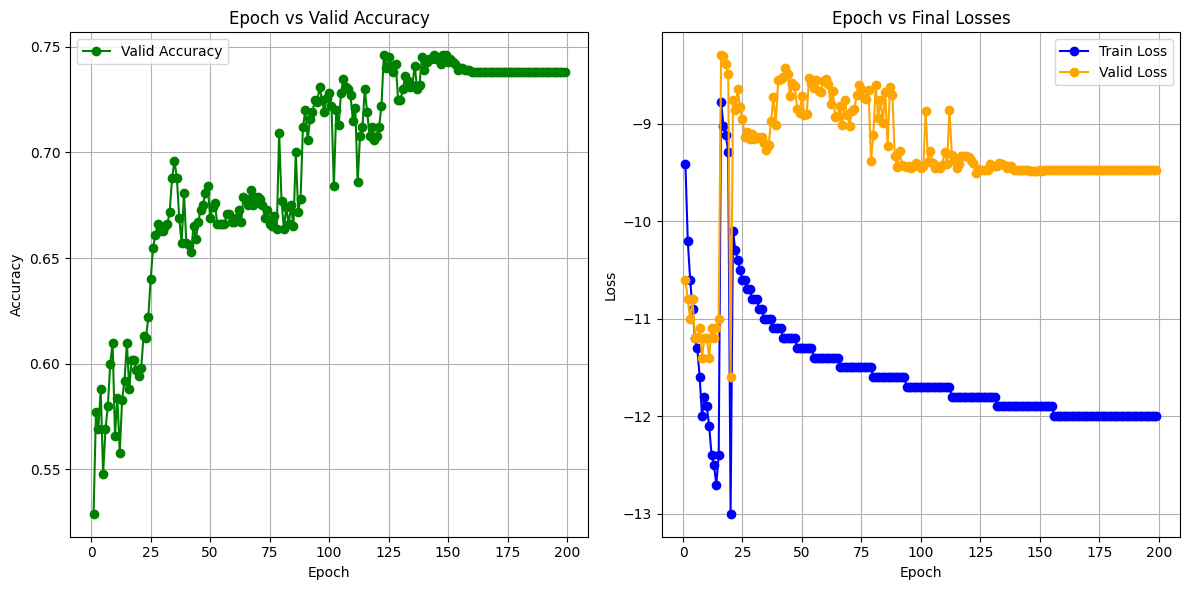

In [9]:
from logging import NullHandler
import re
import matplotlib.pyplot as plt

# Initialize empty lists
epochs = []
valid_accuracies = []
train_losses = []
valid_losses = []
separate_loss = []
lang_loss = []

# Read and parse the log file
with open('/content/results/convtasnet/1234/train_log.txt', 'r') as file:
  epoch_match = None
  train_loss_match = None
  valid_loss_match = None
  acc_match = None
  for line in file:
      # Use regular expressions to extract values
      if(epoch_match == None):
        epoch_match = re.search(r'epoch: (\d+)', line)
      if(acc_match == None):
        acc_match = re.search(r'valid Accuracy Partial: ([\deE\+\-\.]+)', line)
      if(train_loss_match == None):
        train_loss_match = re.search(r'train final_loss: ([\deE\+\-\.]+)', line)
      if(valid_loss_match == None):
        valid_loss_match = re.search(r'valid final_loss: ([\deE\+\-\.]+)', line)
      # print(valid_loss_match)
      # separate_loss_match = re.search(r'valid separate_loss: ([\deE\+\-\.]+)', line)
      # lang_loss_match = re.search(r'valid lang_loss: ([\deE\+\-\.]+)', line)

      if epoch_match and train_loss_match and valid_loss_match :
          epochs.append(int(epoch_match.group(1)))
          valid_accuracies.append(float(acc_match.group(1)))
          train_losses.append(float(train_loss_match.group(1)))
          valid_losses.append(float(valid_loss_match.group(1)))
          epoch_match = None
          train_loss_match = None
          valid_loss_match = None

          acc_match = None

print(train_losses)
print(valid_losses)
print(valid_accuracies)
# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, valid_accuracies, marker='o', label='Valid Accuracy', color='green')
plt.title("Epoch vs Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, marker='o', label='Train Loss', color='blue')
plt.plot(epochs, valid_losses, marker='o', label='Valid Loss', color='orange')
# plt.plot(epochs, separate_loss, marker='o', label='Separate Loss', color='red')
# plt.plot(epochs, lang_loss, marker='o', label='Lang Loss', color='purple')
plt.title("Epoch vs Final Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Evaluate

In [ ]:
# Eval
separator.evaluate( test_data, min_key="si-snr")

speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
Delta lang loss = 0.2, Delta separate loss = 0.8


100%|██████████| 750/750 [00:53<00:00, 14.12it/s]

speechbrain.utils.train_logger - Epoch loaded: 200 - test final_loss: -9.32e+00, test Accuracy soft: 0.3648347556591034, test Accuracy Partial: 0.737333357334137


-9.31976790662607

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
separator.save_results(test_data)

 33%|███▎      | 249/750 [03:50<07:43,  1.08it/s]


AttributeError: 'PaddedData' object has no attribute 'squeeze'

End Run

In [ ]:
!rm -rf /content/results
# !cp -r /content/results /content/drive/MyDrive/Project/
# !cp -r /content/hparams/conVasNet.yml /content/drive/MyDrive/Project/results/

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
!cp /content/hparams/conVasNet_p.yml /content/drive/MyDrive/Project

In [ ]:
# import torch
# import torch.nn as nn
# # from speechbrain.nnet.losses import PitWrapper
# # pit_bceeee = PitWrapper(nn.NLLLoss(reduction ='none'))
# loss_1 = nn.CrossEntropyLoss(reduction = 'none')
# loss_2 = nn.CrossEntropyLoss(reduction='mean')
# n = 0
# while n!=100:
#   input = torch.randn(1,2, 16, requires_grad=True)
#   target = torch.empty(1,2,16, dtype=torch.long).random_(1)
#   target[0][1][5] = 1
#   target[0][0][8] = 1
#   input = input.squeeze(0)
#   target = target.squeeze(0)
#   targets = (target == 1).nonzero(as_tuple=False)
#   input_first, input_second = torch.chunk(input, chunks = 2, dim=0)
#   target_first, target_second = torch.chunk(targets, chunks = 2, dim=0)
#   target_first = target_first.squeeze(0)[1:]
#   target_second = target_second.squeeze(0)[1:]
#   # print(type(input_first),target_first,target_second)
#   lang_loss = 0.5*torch.min(torch.stack([(loss_1(input_first,target_first)+loss_1(input_second,target_second)), (loss_1(input_first,target_second)+loss_1(input_second,target_first))]))
#   # print(lang_loss)
#   target_2 = target.argmax(dim = 1)
#   # print(input,target_2,target_2.flip(0))
#   lang_loss_2 = torch.min(torch.stack([loss_2(input,target_2),loss_2(input,target_2.flip(0))]))
#   # print(lang_loss_2)
#   if(lang_loss != lang_loss_2):
#     print(f"Different for {input}")
#   n = n +1